In [2]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.
/home/omid/.conda/envs/iot_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load the data

In [3]:
x_data= [] 
y_data= [] 

with open( '../files/txt/seq_mapping_large.txt' ) as f:
    x_data = f.readlines()

with open( '../files/txt/command_mapping_large.txt' ) as f:
    y_data = f.readlines()
    
    
x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
y_data =[ x.strip().split(' ') for x in  y_data ] 


In [4]:
def pre_process_raw( x_data,y_data, dim_size = 128, zero_pad = False, normalize = False  ):
#  y data 
    classes  = list(np.unique(  np.concatenate( y_data  )))
    y_data_categorical = []  

    for x in y_data:
        temp = np.zeros( len(classes) )
        for y in x : 
            temp[ classes.index( y ) ] = 1
        y_data_categorical.append( temp )
    y_data_categorical = np.vstack(y_data_categorical)

#     x_data = np.array( x_data) / 1500.0
    
    x_data_temp = [] 
    
    if not zero_pad:
        for x in x_data:
            temp = [] #list(x)
            lst = list(x)
            while dim_size**2 - len(temp )   > len(lst):
                temp.extend(lst)

            while len(temp) < dim_size**2:
                temp.append( 0 )

            x_data_temp.append(np.array( temp).reshape(dim_size,dim_size))


        x_data_temp = np.array( x_data_temp )
        x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / 1500.0
    else :
        x_data_temp = np.array(x_data_temp)
    
    
    return x_data_temp ,y_data_categorical , classes

In [5]:
def pre_process_simple_catagories( x_data,y_data,dim_size =128, zero_pad = False, normalize = False ):
#  y data 
    the_mappings = { 
        'Kwikset_10-Button_Deadbolt_activity_hubDisconnected':0,
 'Kwikset_10-Button_Deadbolt_activity_online':0,
 'Kwikset_10-Button_Deadbolt_lock_locked':1,
 'Kwikset_10-Button_Deadbolt_lock_unlocked':1,
 'Multipurpose_Sensor_acceleration_active':2,
 'Multipurpose_Sensor_acceleration_inactive':2,
 'Multipurpose_Sensor_activity_hubDisconnected':3,
 'Multipurpose_Sensor_activity_online':3,
 'Multipurpose_Sensor_contact_closed':4,
 'Multipurpose_Sensor_contact_open':4,
 'Multipurpose_Sensor_status_closed':4,
 'Multipurpose_Sensor_status_open':4,
 'Multipurpose_Sensor_temperature_XXX':5,
 'Multipurpose_Sensor_threeAxis_XXX':5,
 'OSRAM_LIGHTIFY_Dimming_Switch_activity_hubDisconnected':6,
 'OSRAM_LIGHTIFY_Dimming_Switch_activity_online':6,
 'OSRAM_LIGHTIFY_Dimming_Switch_button_held':7,
 'OSRAM_LIGHTIFY_Dimming_Switch_button_pushed':8,
 'SYLVANIA_SMART+_Smart_Plug_switch_off':9,
 'SYLVANIA_SMART+_Smart_Plug_switch_on':9,
 'SYLVANIA_Smart_10Y_A19_TW_activity_hubDisconnected':10,
 'SYLVANIA_Smart_10Y_A19_TW_activity_offline':10,
 'SYLVANIA_Smart_10Y_A19_TW_activity_online':10,
 'SYLVANIA_Smart_10Y_A19_TW_colorTemperature_XXX' : 11,
 'SYLVANIA_Smart_10Y_A19_TW_level_XXX':12,
 'SYLVANIA_Smart_10Y_A19_TW_switch_off':13,
 'SYLVANIA_Smart_10Y_A19_TW_switch_on':13
    }

    classes  = list(np.unique(  np.concatenate( y_data  )))
    y_data_categorical = []  

    
    for x in y_data:
        temp = np.zeros( 14 )
        for y in x : 
            temp[ the_mappings[y] ] = 1
        y_data_categorical.append(temp)
    y_data_categorical = np.vstack(y_data_categorical)

    
    
    x_data_temp = [] 
    
    if not zero_pad:
        for x in x_data:
            temp = [] #list(x)
            lst = list(x)
            while dim_size**2 - len(temp )   > len(lst):
                temp.extend(lst)

            while len(temp) < dim_size**2:
                temp.append( 0 )

            x_data_temp.append(np.array( temp).reshape(dim_size,dim_size))


        x_data_temp = np.array( x_data_temp )
        x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    if normalize:
        x_data_temp = np.array( x_data_temp) / 1500.0
    else :
        x_data_temp = np.array(x_data_temp)
        
    return x_data_temp ,y_data_categorical , classes

# Create the Model 

In [5]:
dim_size =128
x,y, classes = pre_process_simple_catagories( x_data, y_data , dim_size)

In [6]:
def baseline_model(dim_size,class_count ):
    
    model = Sequential()
    model.add(keras.layers.Flatten(input_shape=(dim_size,dim_size,1)))
    model.add(keras.layers.Dense(320, activation=tf.nn.relu))
    model.add(keras.layers.Dense(class_count, activation=tf.nn.softmax))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    
    return model

#     # create model
#     model = Sequential()
#     model.add(Dense(320, input_dim=160, activation='relu'))
#     model.add(Dense(len(classes), activation='softmax'))
#     # Compile model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [7]:
import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2

def unet(dim_size , classcount):
    l2_lambda = 0.0002
    DropP = 0.3
    kernel_size=3

    inputs = Input((dim_size,dim_size,1))
    
    
    conv1 = Conv2D( 32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(inputs)
    conv1 = bn()(conv1)
    conv1 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv1)
    conv1 = bn()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(DropP)(pool1)





    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool1)
    conv2 = bn()(conv2)
    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv2)
    conv2 = bn()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(DropP)(pool2)



    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool2)
    conv3 = bn()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv3)
    conv3 = bn()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(DropP)(pool3)



    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool3)
    conv4 = bn()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv4)
    conv4 = bn()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(DropP)(pool4)



    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool4)
    conv5 = bn()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv5)
    conv5 = bn()(conv5)
    
    up6 = concatenate([Conv2DTranspose(256,(2, 2), strides=(2, 2), padding='same')(conv5), conv4],name='up6', axis=3)
    up6 = Dropout(DropP)(up6)
    conv6 = Conv2D(256,(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up6)
    conv6 = bn()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv6)

    conv6 = bn()(conv6)
    up7 = concatenate([Conv2DTranspose(128,(2, 2), strides=(2, 2), padding='same')(conv6), conv3],name='up7', axis=3)
    up7 = Dropout(DropP)(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up7)
    conv7 = bn()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv7)
    conv7 = bn()(conv7)

    up8 = concatenate([Conv2DTranspose(64,(2, 2), strides=(2, 2), padding='same')(conv7), conv2],name='up8', axis=3)
    up8 = Dropout(DropP)(up8)
    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up8)
    conv8 = bn()(conv8)
    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv8)
    conv8 = bn()(conv8)

    up9 = concatenate([Conv2DTranspose(32,(2, 2), strides=(2, 2), padding='same')(conv8), conv1],name='up9',axis=3)
    up9 = Dropout(DropP)(up9)
    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up9)
    conv9 = bn()(conv9)
    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv9)
    conv9 = bn()(conv9) 
    
    
    #Conv3D(filters,(3,3,3),sjfsjf)
#     conv1 = Conv2D(16, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(inputs)
#     conv1 = bn()(conv1)
#     conv1 = Conv2D(16, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv1)
#     conv1 = bn()(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     pool1 = Dropout(DropP)(pool1)

#     conv2 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool1)
#     conv2 = bn()(conv2)
#     conv2 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv2)
#     conv2 = bn()(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     pool2 = Dropout(DropP)(pool2)

#     conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool2)
#     conv3 = bn()(conv3)
#     conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv3)
#     conv3 = bn()(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     pool3 = Dropout(DropP)(pool3)
    
#     conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool2)
#     conv4 = bn()(conv4)
#     conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv4)
#     conv4 = bn()(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
#     pool4 = Dropout(DropP)(pool4)

#     conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool4)
#     conv5 = bn()(conv5)
#     conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv5)
#     conv5 = bn()(conv5)
    
    
#     up6 = concatenate([Conv2DTranspose(128,(2, 2), strides=(2, 2), padding='same')(conv5), conv4],name='up6', axis=3)
#     up6 = Dropout(DropP)(up6)
#     conv6 = Conv2D(128,(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up6)
#     conv6 = bn()(conv6)
#     conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv6)

#     conv6 = bn()(conv6)
#     up7 = concatenate([Conv2DTranspose(64,(2, 2), strides=(2, 2), padding='same')(conv6), conv3],name='up7', axis=3)
#     up7 = Dropout(DropP)(up7)
#     conv7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up7)
#     conv7 = bn()(conv7)
#     conv7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv7)
#     conv7 = bn()(conv7)

#     up8 = concatenate([Conv2DTranspose(32,(2, 2), strides=(2, 2), padding='same')(conv7), conv2],name='up8', axis=3)
#     up8 = Dropout(DropP)(up8)
#     conv8 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up8)
#     conv8 = bn()(conv8)
#     conv8 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv8)
#     conv8 = bn()(conv8)

#     up9 = concatenate([Conv2DTranspose(16,(2, 2), strides=(2, 2), padding='same')(conv8), conv1],name='up9',axis=3)
#     up9 = Dropout(DropP)(up9)
#     conv9 = Conv2D(16, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up9)
#     conv9 = bn()(conv9)
#     conv9 = Conv2D(16, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv9)
#     conv9 = bn()(conv9)   
    
    
    flatten1 = Flatten()(conv9)
    conv7 = Dense( 256, activation='relu' )(flatten1)
    conv8 = Dense( 128, activation='relu' )(conv7)
    
    
    output = Dense(classcount,  activation='softmax',name='output')(conv8)
    
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
def simpleConv (dim_size ,classcount):
    num_classes = classcount
    model = model = Sequential()
    model.add(Conv2D(320, kernel_size=(3, 3),
                 activation='relu',
                 input_shape= ( dim_size ,dim_size ,1 )))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [ ]:
def simpleLSTM( word_count,dim_size  ):
    embedding_vecor_length = 102
    model = Sequential()
    model.add(Embedding(word_count, embedding_vecor_length, input_length=dim_size))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))

    model.add(Dense(14, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model 


In [ ]:
def betterLSTM(  ):
    dim_size =160

    word_count = np.max( x)+1 # len(np.unique( x ))

    # create the model
    embedding_vecor_length = 102
    model = Sequential()
    model.add(Embedding(word_count, embedding_vecor_length, input_length=dim_size))
    model.add(Dropout(0.1))
    model.add(LSTM(100))

    model.add(Dense(127, activation='relu'))
    model.add(Dense(27, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
#model = baseline_model()
#report = model.fit( x=x_data_temp , y=y_data_categorical , batch_size=35, epochs=12000 )

In [10]:
# x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))

model2 = unet(dim_size,len( y[0]))
model2.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 128, 32)  320         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 128, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 128, 128, 32)  9248        batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [11]:
report2 = model2.fit( x=x , y=y , batch_size=35, epochs=1200 )

Epoch 1/1200
431/431 [==============================] - 8s - loss: 3.5673 - acc: 0.4919     
Epoch 2/1200
431/431 [==============================] - 3s - loss: 2.4048 - acc: 0.6682     
Epoch 3/1200
431/431 [==============================] - 3s - loss: 2.1472 - acc: 0.6961     
Epoch 4/1200
431/431 [==============================] - 3s - loss: 2.0098 - acc: 0.7517     
Epoch 5/1200
431/431 [==============================] - 3s - loss: 1.9637 - acc: 0.7471     
Epoch 6/1200
431/431 [==============================] - 3s - loss: 1.9493 - acc: 0.7262     
Epoch 7/1200
431/431 [==============================] - 3s - loss: 1.8388 - acc: 0.7564     
Epoch 8/1200
431/431 [==============================] - 3s - loss: 1.9193 - acc: 0.7842     
Epoch 9/1200
431/431 [==============================] - 3s - loss: 1.8705 - acc: 0.7865     
Epoch 10/1200
431/431 [==============================] - 3s - loss: 1.7991 - acc: 0.7680     
Epoch 11/1200
431/431 [==============================] - 3s - loss: 1

431/431 [==============================] - 3s - loss: 1.4973 - acc: 0.7912     
Epoch 175/1200
431/431 [==============================] - 3s - loss: 1.5010 - acc: 0.7981     
Epoch 176/1200
431/431 [==============================] - 3s - loss: 1.4904 - acc: 0.8422     
Epoch 177/1200
431/431 [==============================] - 3s - loss: 1.5266 - acc: 0.8051     
Epoch 178/1200
431/431 [==============================] - 3s - loss: 1.5237 - acc: 0.8005     
Epoch 179/1200
431/431 [==============================] - 3s - loss: 1.5270 - acc: 0.7935     
Epoch 180/1200
431/431 [==============================] - 3s - loss: 1.4879 - acc: 0.8190     
Epoch 181/1200
431/431 [==============================] - 3s - loss: 1.5319 - acc: 0.8144     
Epoch 182/1200
431/431 [==============================] - 3s - loss: 1.5376 - acc: 0.7819     
Epoch 183/1200
431/431 [==============================] - 3s - loss: 1.5274 - acc: 0.8167     
Epoch 184/1200
431/431 [==============================] - 3s - lo

431/431 [==============================] - 3s - loss: 1.4776 - acc: 0.8074     
Epoch 347/1200
431/431 [==============================] - 3s - loss: 1.4580 - acc: 0.7865     
Epoch 348/1200
431/431 [==============================] - 3s - loss: 1.4667 - acc: 0.8028     
Epoch 349/1200
431/431 [==============================] - 3s - loss: 1.4724 - acc: 0.7935     
Epoch 350/1200
431/431 [==============================] - 3s - loss: 1.4721 - acc: 0.8028     
Epoch 351/1200
431/431 [==============================] - 3s - loss: 1.4535 - acc: 0.8097     
Epoch 352/1200
431/431 [==============================] - 3s - loss: 1.4685 - acc: 0.8005     
Epoch 353/1200
431/431 [==============================] - 3s - loss: 1.4630 - acc: 0.8051     
Epoch 354/1200
431/431 [==============================] - 3s - loss: 1.4703 - acc: 0.7981     
Epoch 355/1200
431/431 [==============================] - 3s - loss: 1.4682 - acc: 0.8005     
Epoch 356/1200
431/431 [==============================] - 3s - lo

431/431 [==============================] - 3s - loss: 1.4361 - acc: 0.8167     
Epoch 519/1200
431/431 [==============================] - 3s - loss: 1.4422 - acc: 0.8028     
Epoch 520/1200
431/431 [==============================] - 3s - loss: 1.4395 - acc: 0.8283     
Epoch 521/1200
431/431 [==============================] - 3s - loss: 1.4507 - acc: 0.7773     
Epoch 522/1200
431/431 [==============================] - 3s - loss: 1.4301 - acc: 0.7958     
Epoch 523/1200
431/431 [==============================] - 3s - loss: 1.4365 - acc: 0.8121     
Epoch 524/1200
431/431 [==============================] - 3s - loss: 1.4418 - acc: 0.8074     
Epoch 525/1200
431/431 [==============================] - 3s - loss: 1.4437 - acc: 0.7842     
Epoch 526/1200
431/431 [==============================] - 3s - loss: 1.4408 - acc: 0.7912     
Epoch 527/1200
431/431 [==============================] - 3s - loss: 1.4356 - acc: 0.8074     
Epoch 528/1200
431/431 [==============================] - 3s - lo

431/431 [==============================] - 3s - loss: 1.4933 - acc: 0.8005     
Epoch 691/1200
431/431 [==============================] - 3s - loss: 1.4939 - acc: 0.8028     
Epoch 692/1200
431/431 [==============================] - 3s - loss: 1.5130 - acc: 0.8097     
Epoch 693/1200
431/431 [==============================] - 3s - loss: 1.4894 - acc: 0.7958     
Epoch 694/1200
431/431 [==============================] - 3s - loss: 1.4895 - acc: 0.8144     
Epoch 695/1200
431/431 [==============================] - 3s - loss: 1.4878 - acc: 0.7935     
Epoch 696/1200
431/431 [==============================] - 3s - loss: 1.5089 - acc: 0.8051     
Epoch 697/1200
431/431 [==============================] - 3s - loss: 1.5100 - acc: 0.7981     
Epoch 698/1200
431/431 [==============================] - 3s - loss: 1.4890 - acc: 0.7912     
Epoch 699/1200
431/431 [==============================] - 3s - loss: 1.4833 - acc: 0.7981     
Epoch 700/1200
431/431 [==============================] - 3s - lo

431/431 [==============================] - 3s - loss: 1.4649 - acc: 0.8237     
Epoch 863/1200
431/431 [==============================] - 3s - loss: 1.4809 - acc: 0.7865     
Epoch 864/1200
431/431 [==============================] - 3s - loss: 1.4598 - acc: 0.8283     
Epoch 865/1200
431/431 [==============================] - 3s - loss: 1.4349 - acc: 0.7912     
Epoch 866/1200
431/431 [==============================] - 3s - loss: 1.4401 - acc: 0.8167     
Epoch 867/1200
431/431 [==============================] - 3s - loss: 1.4485 - acc: 0.8097     
Epoch 868/1200
431/431 [==============================] - 3s - loss: 1.4381 - acc: 0.8399     
Epoch 869/1200
431/431 [==============================] - 3s - loss: 1.4444 - acc: 0.8190     
Epoch 870/1200
431/431 [==============================] - 3s - loss: 1.4414 - acc: 0.7842     
Epoch 871/1200
431/431 [==============================] - 3s - loss: 1.4629 - acc: 0.8051     
Epoch 872/1200
431/431 [==============================] - 3s - lo

431/431 [==============================] - 3s - loss: 1.4016 - acc: 0.8144     
Epoch 1035/1200
431/431 [==============================] - 3s - loss: 1.3825 - acc: 0.8097     
Epoch 1036/1200
431/431 [==============================] - 3s - loss: 1.3955 - acc: 0.8283     
Epoch 1037/1200
431/431 [==============================] - 3s - loss: 1.3912 - acc: 0.8028     
Epoch 1038/1200
431/431 [==============================] - 3s - loss: 1.3922 - acc: 0.8144     
Epoch 1039/1200
431/431 [==============================] - 3s - loss: 1.3863 - acc: 0.8028     
Epoch 1040/1200
431/431 [==============================] - 3s - loss: 1.3948 - acc: 0.8306     
Epoch 1041/1200
431/431 [==============================] - 3s - loss: 1.4034 - acc: 0.8167     
Epoch 1042/1200
431/431 [==============================] - 3s - loss: 1.3890 - acc: 0.8167     
Epoch 1043/1200
431/431 [==============================] - 3s - loss: 1.4001 - acc: 0.8097     
Epoch 1044/1200
431/431 [==============================]

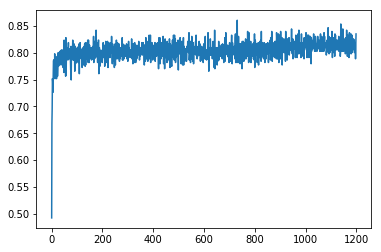

In [12]:
plt.plot(report2.history['acc'])

In [9]:
model3 = simpleConv(dim_size, len( y[0]))
model3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 320)     3200      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 256)     737536    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 128)     295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 120, 120, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 230400)            0         
__________

In [10]:
hist3 = model3.fit( x=x , y=y , batch_size=35, epochs=1200 )

Epoch 1/1200
431/431 [==============================] - 9s - loss: 3.6635 - acc: 0.1879     
Epoch 2/1200
431/431 [==============================] - 4s - loss: 3.1968 - acc: 0.1833     
Epoch 3/1200
431/431 [==============================] - 4s - loss: 3.0475 - acc: 0.1949     
Epoch 4/1200
431/431 [==============================] - 4s - loss: 2.9857 - acc: 0.2135     
Epoch 5/1200
431/431 [==============================] - 4s - loss: 2.9370 - acc: 0.1833     
Epoch 6/1200
431/431 [==============================] - 4s - loss: 2.9283 - acc: 0.2181     
Epoch 7/1200
431/431 [==============================] - 4s - loss: 2.8780 - acc: 0.2343     
Epoch 8/1200
431/431 [==============================] - 4s - loss: 2.8938 - acc: 0.2274     
Epoch 9/1200
431/431 [==============================] - 4s - loss: 2.8623 - acc: 0.2459     
Epoch 10/1200
431/431 [==============================] - 4s - loss: 2.8541 - acc: 0.2599     
Epoch 11/1200
431/431 [==============================] - 4s - loss: 2

431/431 [==============================] - 4s - loss: 1.5197 - acc: 0.6961     
Epoch 175/1200
431/431 [==============================] - 4s - loss: 1.4954 - acc: 0.7123     
Epoch 176/1200
431/431 [==============================] - 4s - loss: 1.5355 - acc: 0.7100     
Epoch 177/1200
431/431 [==============================] - 4s - loss: 1.5299 - acc: 0.7146     
Epoch 178/1200
431/431 [==============================] - 4s - loss: 1.5290 - acc: 0.7146     
Epoch 179/1200
431/431 [==============================] - 4s - loss: 1.5398 - acc: 0.7123     
Epoch 180/1200
431/431 [==============================] - 4s - loss: 1.5507 - acc: 0.7216     
Epoch 181/1200
431/431 [==============================] - 4s - loss: 1.5070 - acc: 0.6914     
Epoch 182/1200
431/431 [==============================] - 4s - loss: 1.4875 - acc: 0.6868     
Epoch 183/1200
431/431 [==============================] - 4s - loss: 1.5044 - acc: 0.6821     
Epoch 184/1200
431/431 [==============================] - 4s - lo

431/431 [==============================] - 4s - loss: 1.3105 - acc: 0.7494     
Epoch 347/1200
431/431 [==============================] - 4s - loss: 1.3072 - acc: 0.7517     
Epoch 348/1200
431/431 [==============================] - 4s - loss: 1.3286 - acc: 0.7285     
Epoch 349/1200
431/431 [==============================] - 4s - loss: 1.3301 - acc: 0.7657     
Epoch 350/1200
431/431 [==============================] - 4s - loss: 1.3149 - acc: 0.7448     
Epoch 351/1200
431/431 [==============================] - 4s - loss: 1.2972 - acc: 0.7564     
Epoch 352/1200
431/431 [==============================] - 4s - loss: 1.2912 - acc: 0.7680     
Epoch 353/1200
431/431 [==============================] - 4s - loss: 1.2817 - acc: 0.7726     
Epoch 354/1200
431/431 [==============================] - 4s - loss: 1.2925 - acc: 0.7517     
Epoch 355/1200
431/431 [==============================] - 4s - loss: 1.3119 - acc: 0.7494     
Epoch 356/1200
431/431 [==============================] - 4s - lo

431/431 [==============================] - 4s - loss: 1.1830 - acc: 0.7633     
Epoch 519/1200
431/431 [==============================] - 4s - loss: 1.1723 - acc: 0.7796     
Epoch 520/1200
431/431 [==============================] - 4s - loss: 1.1987 - acc: 0.7773     
Epoch 521/1200
431/431 [==============================] - 4s - loss: 1.1646 - acc: 0.7610     
Epoch 522/1200
431/431 [==============================] - 4s - loss: 1.2303 - acc: 0.7703     
Epoch 523/1200
431/431 [==============================] - 4s - loss: 1.1804 - acc: 0.7610     
Epoch 524/1200
431/431 [==============================] - 4s - loss: 1.2135 - acc: 0.7633     
Epoch 525/1200
431/431 [==============================] - 4s - loss: 1.1659 - acc: 0.7819     
Epoch 526/1200
431/431 [==============================] - 4s - loss: 1.2146 - acc: 0.7610     
Epoch 527/1200
431/431 [==============================] - 4s - loss: 1.1811 - acc: 0.7680     
Epoch 528/1200
431/431 [==============================] - 4s - lo

431/431 [==============================] - 4s - loss: 1.1456 - acc: 0.7773     
Epoch 691/1200
431/431 [==============================] - 4s - loss: 1.1113 - acc: 0.7633     
Epoch 692/1200
431/431 [==============================] - 4s - loss: 1.1386 - acc: 0.7819     
Epoch 693/1200
431/431 [==============================] - 4s - loss: 1.1383 - acc: 0.7865     
Epoch 694/1200
431/431 [==============================] - 4s - loss: 1.1299 - acc: 0.7819     
Epoch 695/1200
431/431 [==============================] - 4s - loss: 1.1174 - acc: 0.7680     
Epoch 696/1200
431/431 [==============================] - 4s - loss: 1.1501 - acc: 0.7935     
Epoch 697/1200
431/431 [==============================] - 4s - loss: 1.1293 - acc: 0.7680     
Epoch 698/1200
431/431 [==============================] - 4s - loss: 1.1133 - acc: 0.7773     
Epoch 699/1200
431/431 [==============================] - 4s - loss: 1.1418 - acc: 0.7773     
Epoch 700/1200
431/431 [==============================] - 4s - lo

431/431 [==============================] - 4s - loss: 1.0707 - acc: 0.7842     
Epoch 863/1200
431/431 [==============================] - 4s - loss: 1.0587 - acc: 0.7819     
Epoch 864/1200
431/431 [==============================] - 4s - loss: 1.0911 - acc: 0.7935     
Epoch 865/1200
431/431 [==============================] - 4s - loss: 1.0967 - acc: 0.7796     
Epoch 866/1200
431/431 [==============================] - 4s - loss: 1.0697 - acc: 0.7796     
Epoch 867/1200
431/431 [==============================] - 4s - loss: 1.0792 - acc: 0.7703     
Epoch 868/1200
431/431 [==============================] - 4s - loss: 1.0665 - acc: 0.8005     
Epoch 869/1200
431/431 [==============================] - 4s - loss: 1.0995 - acc: 0.7726     
Epoch 870/1200
431/431 [==============================] - 4s - loss: 1.0942 - acc: 0.7981     
Epoch 871/1200
431/431 [==============================] - 4s - loss: 1.0693 - acc: 0.8167     
Epoch 872/1200
431/431 [==============================] - 4s - lo

431/431 [==============================] - 4s - loss: 1.0602 - acc: 0.7680     
Epoch 1035/1200
431/431 [==============================] - 4s - loss: 1.0778 - acc: 0.7912     
Epoch 1036/1200
431/431 [==============================] - 4s - loss: 1.0632 - acc: 0.7726     
Epoch 1037/1200
431/431 [==============================] - 4s - loss: 1.0495 - acc: 0.7796     
Epoch 1038/1200
431/431 [==============================] - 4s - loss: 1.0462 - acc: 0.7842     
Epoch 1039/1200
431/431 [==============================] - 4s - loss: 1.0415 - acc: 0.7889     
Epoch 1040/1200
431/431 [==============================] - 4s - loss: 1.0639 - acc: 0.7773     
Epoch 1041/1200
431/431 [==============================] - 4s - loss: 1.0371 - acc: 0.7842     
Epoch 1042/1200
431/431 [==============================] - 4s - loss: 1.0615 - acc: 0.7819     
Epoch 1043/1200
431/431 [==============================] - 4s - loss: 1.0564 - acc: 0.7889     
Epoch 1044/1200
431/431 [==============================]

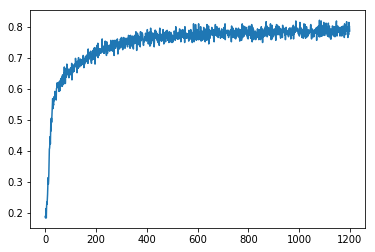

In [11]:
plt.plot(hist3.history['acc'])

In [12]:
model4 = baseline_model(dim_size, len( y[0]))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 320)               5243200   
_________________________________________________________________
dense_5 (Dense)              (None, 14)                4494      
Total params: 5,247,694
Trainable params: 5,247,694
Non-trainable params: 0
_________________________________________________________________


In [13]:
hist4 = model4.fit( x=x , y=y , batch_size=35, epochs=1200 )

Epoch 1/1200
431/431 [==============================] - 0s - loss: 10.4983 - acc: 0.2042     
Epoch 2/1200
431/431 [==============================] - 0s - loss: 9.4824 - acc: 0.2993     
Epoch 3/1200
431/431 [==============================] - 0s - loss: 9.2228 - acc: 0.3666     
Epoch 4/1200
431/431 [==============================] - 0s - loss: 8.2684 - acc: 0.3944     
Epoch 5/1200
431/431 [==============================] - 0s - loss: 7.4132 - acc: 0.3712     
Epoch 6/1200
431/431 [==============================] - 0s - loss: 7.3194 - acc: 0.3387     
Epoch 7/1200
431/431 [==============================] - 0s - loss: 7.1660 - acc: 0.4107     
Epoch 8/1200
431/431 [==============================] - 0s - loss: 7.0788 - acc: 0.4200     
Epoch 9/1200
431/431 [==============================] - 0s - loss: 7.0668 - acc: 0.4617     
Epoch 10/1200
431/431 [==============================] - 0s - loss: 6.9762 - acc: 0.4710     
Epoch 11/1200
431/431 [==============================] - 0s - loss: 

431/431 [==============================] - 0s - loss: 1.0231 - acc: 0.7657     
Epoch 175/1200
431/431 [==============================] - 0s - loss: 0.9944 - acc: 0.8074     
Epoch 176/1200
431/431 [==============================] - 0s - loss: 1.0173 - acc: 0.7865     
Epoch 177/1200
431/431 [==============================] - 0s - loss: 1.0049 - acc: 0.7773     
Epoch 178/1200
431/431 [==============================] - 0s - loss: 1.0255 - acc: 0.7865     
Epoch 179/1200
431/431 [==============================] - 0s - loss: 1.0583 - acc: 0.7726     
Epoch 180/1200
431/431 [==============================] - 0s - loss: 1.0144 - acc: 0.8005     
Epoch 181/1200
431/431 [==============================] - 0s - loss: 0.9945 - acc: 0.7703     
Epoch 182/1200
431/431 [==============================] - 0s - loss: 0.9727 - acc: 0.8005     
Epoch 183/1200
431/431 [==============================] - 0s - loss: 0.9722 - acc: 0.7935     
Epoch 184/1200
431/431 [==============================] - 0s - lo

431/431 [==============================] - 0s - loss: 0.9617 - acc: 0.7935     
Epoch 347/1200
431/431 [==============================] - 0s - loss: 0.9995 - acc: 0.7842     
Epoch 348/1200
431/431 [==============================] - 0s - loss: 1.0099 - acc: 0.7726     
Epoch 349/1200
431/431 [==============================] - 0s - loss: 0.9496 - acc: 0.7726     
Epoch 350/1200
431/431 [==============================] - 0s - loss: 0.9618 - acc: 0.8144     
Epoch 351/1200
431/431 [==============================] - 0s - loss: 0.9721 - acc: 0.7865     
Epoch 352/1200
431/431 [==============================] - 0s - loss: 0.9829 - acc: 0.7842     
Epoch 353/1200
431/431 [==============================] - 0s - loss: 0.9804 - acc: 0.7912     
Epoch 354/1200
431/431 [==============================] - 0s - loss: 0.9466 - acc: 0.7958     
Epoch 355/1200
431/431 [==============================] - 0s - loss: 0.9564 - acc: 0.7680     
Epoch 356/1200
431/431 [==============================] - 0s - lo

431/431 [==============================] - 0s - loss: 0.9669 - acc: 0.7796     
Epoch 519/1200
431/431 [==============================] - 0s - loss: 0.9443 - acc: 0.7749     
Epoch 520/1200
431/431 [==============================] - 0s - loss: 0.9428 - acc: 0.7865     
Epoch 521/1200
431/431 [==============================] - 0s - loss: 0.9444 - acc: 0.8144     
Epoch 522/1200
431/431 [==============================] - 0s - loss: 0.9654 - acc: 0.7865     
Epoch 523/1200
431/431 [==============================] - 0s - loss: 0.9466 - acc: 0.7935     
Epoch 524/1200
431/431 [==============================] - 0s - loss: 0.9464 - acc: 0.7796     
Epoch 525/1200
431/431 [==============================] - 0s - loss: 0.9540 - acc: 0.7819     
Epoch 526/1200
431/431 [==============================] - 0s - loss: 0.9585 - acc: 0.7958     
Epoch 527/1200
431/431 [==============================] - 0s - loss: 0.9370 - acc: 0.8376     
Epoch 528/1200
431/431 [==============================] - 0s - lo

431/431 [==============================] - 0s - loss: 0.9523 - acc: 0.8005     
Epoch 691/1200
431/431 [==============================] - 0s - loss: 0.9798 - acc: 0.7471     
Epoch 692/1200
431/431 [==============================] - 0s - loss: 0.9496 - acc: 0.8260     
Epoch 693/1200
431/431 [==============================] - 0s - loss: 0.9572 - acc: 0.7657     
Epoch 694/1200
431/431 [==============================] - 0s - loss: 0.9406 - acc: 0.7680     
Epoch 695/1200
431/431 [==============================] - 0s - loss: 0.9354 - acc: 0.7796     
Epoch 696/1200
431/431 [==============================] - 0s - loss: 0.9230 - acc: 0.7981     
Epoch 697/1200
431/431 [==============================] - 0s - loss: 0.9313 - acc: 0.7935     
Epoch 698/1200
431/431 [==============================] - 0s - loss: 0.9410 - acc: 0.8005     
Epoch 699/1200
431/431 [==============================] - 0s - loss: 0.9443 - acc: 0.7796     
Epoch 700/1200
431/431 [==============================] - 0s - lo

431/431 [==============================] - 0s - loss: 0.9287 - acc: 0.8097     
Epoch 863/1200
431/431 [==============================] - 0s - loss: 0.9170 - acc: 0.7796     
Epoch 864/1200
431/431 [==============================] - 0s - loss: 0.9162 - acc: 0.7958     
Epoch 865/1200
431/431 [==============================] - 0s - loss: 0.9177 - acc: 0.7912     
Epoch 866/1200
431/431 [==============================] - 0s - loss: 0.9199 - acc: 0.7773     
Epoch 867/1200
431/431 [==============================] - 0s - loss: 0.9157 - acc: 0.7981     
Epoch 868/1200
431/431 [==============================] - 0s - loss: 0.9397 - acc: 0.7842     
Epoch 869/1200
431/431 [==============================] - 0s - loss: 0.9212 - acc: 0.8051     
Epoch 870/1200
431/431 [==============================] - 0s - loss: 0.9348 - acc: 0.7703     
Epoch 871/1200
431/431 [==============================] - 0s - loss: 0.9247 - acc: 0.7796     
Epoch 872/1200
431/431 [==============================] - 0s - lo

431/431 [==============================] - 0s - loss: 0.9145 - acc: 0.7958     
Epoch 1035/1200
431/431 [==============================] - 0s - loss: 0.9217 - acc: 0.8144     
Epoch 1036/1200
431/431 [==============================] - 0s - loss: 0.9248 - acc: 0.8005     
Epoch 1037/1200
431/431 [==============================] - 0s - loss: 0.9104 - acc: 0.7865     
Epoch 1038/1200
431/431 [==============================] - 0s - loss: 0.9252 - acc: 0.8445     
Epoch 1039/1200
431/431 [==============================] - 0s - loss: 0.9138 - acc: 0.7773     
Epoch 1040/1200
431/431 [==============================] - 0s - loss: 0.9313 - acc: 0.7865     
Epoch 1041/1200
431/431 [==============================] - 0s - loss: 0.9717 - acc: 0.7587     
Epoch 1042/1200
431/431 [==============================] - 0s - loss: 0.9358 - acc: 0.8074     
Epoch 1043/1200
431/431 [==============================] - 0s - loss: 0.9280 - acc: 0.7819     
Epoch 1044/1200
431/431 [==============================]

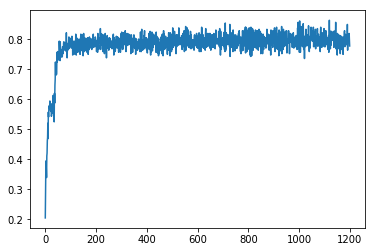

In [14]:
plt.plot(hist4.history['acc'])

In [17]:
print(np.max(report2.history['acc']),np.max(hist3.history['acc']),np.max(hist4.history['acc']))

0.8213457188584136 0.8631090564683529


In [8]:
estimator = KerasClassifier(build_fn=unet,  dim_size=dim_size,classcount= len( y[0]) , epochs=250, batch_size=2, verbose=0)

NameError: name 'unet' is not defined

In [9]:
kfold = KFold(n_splits=5, shuffle=True)

In [7]:
results = cross_val_score(estimator, x, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

NameError: name 'estimator' is not defined

In [12]:
estimator2 = KerasClassifier(build_fn=baseline_model,  dim_size=dim_size,class_count= len( y[0]) , epochs=400, batch_size=45, verbose=0)
results2 = cross_val_score(estimator2, x, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results2.mean()*100, results2.std()*100))

Baseline: 62.42% (6.25%)


# Random Forest baseline calc

In [58]:
dim_size= 160
x,y, classes = pre_process_simple_catagories( x_data, y_data , dim_size, zero_pad=True, normalize=False)
# x,y, classes = pre_process_raw( x_data, y_data , dim_size, zero_pad=True, normalize=True)

In [59]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=260, max_depth=200,
                             random_state=0 )
# clf.fit(x, y)


# print(clf.feature_importances_)

# print(clf.predict([[0, 0, 0, 0]]))
from sklearn import metrics
scores = cross_val_score(clf, x, y, cv=10, scoring='accuracy')

In [60]:
print ( "mean : %f \nstd: %f\nmax:%f" %( scores.mean(), scores.std(), scores.max()) )

mean : 0.754017 
std: 0.103670
max:0.883721


# LSTM 

In [6]:
# create the model
dim_size =160
x,y, classes = pre_process_simple_catagories( x_data, y_data , dim_size, zero_pad=True, normalize=False)

word_count = np.max( x)+1 # len(np.unique( x ))

# create the model
embedding_vecor_length = 102
model = Sequential()
model.add(Embedding(word_count, embedding_vecor_length, input_length=dim_size))
model.add(Dropout(0.1))
model.add(LSTM(100))

model.add(Dense(127, activation='relu'))
model.add(Dense(14, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
hist2 = model.fit(x, y, epochs=1300, batch_size=34)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 160, 102)          129846    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160, 102)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               81200     
_________________________________________________________________
dense_1 (Dense)              (None, 127)               12827     
_________________________________________________________________
dense_2 (Dense)              (None, 14)                1792      
Total params: 225,665
Trainable params: 225,665
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1300
431/431 [==============================] - 5s - loss: 3.7170 - acc: 0.1972     
Epoch 2/1300
431/431 [================

431/431 [==============================] - 3s - loss: 0.7641 - acc: 0.8121     
Epoch 164/1300
431/431 [==============================] - 3s - loss: 0.7626 - acc: 0.8213     
Epoch 165/1300
431/431 [==============================] - 3s - loss: 0.7643 - acc: 0.8353     
Epoch 166/1300
431/431 [==============================] - 3s - loss: 0.7646 - acc: 0.8213     
Epoch 167/1300
431/431 [==============================] - 3s - loss: 0.7645 - acc: 0.8538     
Epoch 168/1300
431/431 [==============================] - 3s - loss: 0.7643 - acc: 0.8237     
Epoch 169/1300
431/431 [==============================] - 3s - loss: 0.7645 - acc: 0.8631     
Epoch 170/1300
431/431 [==============================] - 3s - loss: 0.7632 - acc: 0.8144     
Epoch 171/1300
431/431 [==============================] - 3s - loss: 0.7675 - acc: 0.8283     
Epoch 172/1300
431/431 [==============================] - 3s - loss: 0.7638 - acc: 0.8747     
Epoch 173/1300
431/431 [==============================] - 3s - lo

431/431 [==============================] - 3s - loss: 0.7612 - acc: 0.8422     
Epoch 336/1300
431/431 [==============================] - 3s - loss: 0.7615 - acc: 0.8260     
Epoch 337/1300
431/431 [==============================] - 3s - loss: 0.7631 - acc: 0.8376     
Epoch 338/1300
431/431 [==============================] - 3s - loss: 0.7639 - acc: 0.8213     
Epoch 339/1300
431/431 [==============================] - 3s - loss: 0.7684 - acc: 0.8515     
Epoch 340/1300
431/431 [==============================] - 3s - loss: 0.7654 - acc: 0.8654     
Epoch 341/1300
431/431 [==============================] - 3s - loss: 0.7679 - acc: 0.8144     
Epoch 342/1300
431/431 [==============================] - 3s - loss: 0.7628 - acc: 0.8492     
Epoch 343/1300
431/431 [==============================] - 3s - loss: 0.7651 - acc: 0.8515     
Epoch 344/1300
431/431 [==============================] - 3s - loss: 0.7616 - acc: 0.8492     
Epoch 345/1300
431/431 [==============================] - 3s - lo

431/431 [==============================] - 3s - loss: 0.7606 - acc: 0.8399     
Epoch 508/1300
431/431 [==============================] - 3s - loss: 0.7601 - acc: 0.8492     
Epoch 509/1300
431/431 [==============================] - 3s - loss: 0.7615 - acc: 0.8121     
Epoch 510/1300
431/431 [==============================] - 3s - loss: 0.7596 - acc: 0.8515     
Epoch 511/1300
431/431 [==============================] - 3s - loss: 0.7594 - acc: 0.8144     
Epoch 512/1300
431/431 [==============================] - 3s - loss: 0.7596 - acc: 0.8237     
Epoch 513/1300
431/431 [==============================] - 3s - loss: 0.7592 - acc: 0.7958     
Epoch 514/1300
431/431 [==============================] - 3s - loss: 0.7600 - acc: 0.8353     
Epoch 515/1300
431/431 [==============================] - 3s - loss: 0.7593 - acc: 0.8237     
Epoch 516/1300
431/431 [==============================] - 3s - loss: 0.7586 - acc: 0.8306     
Epoch 517/1300
431/431 [==============================] - 3s - lo

431/431 [==============================] - 3s - loss: 0.7581 - acc: 0.8353     
Epoch 680/1300
431/431 [==============================] - 3s - loss: 0.7586 - acc: 0.8469     
Epoch 681/1300
431/431 [==============================] - 3s - loss: 0.7590 - acc: 0.8237     
Epoch 682/1300
431/431 [==============================] - 3s - loss: 0.7579 - acc: 0.8585     
Epoch 683/1300
431/431 [==============================] - 3s - loss: 0.7582 - acc: 0.8353     
Epoch 684/1300
431/431 [==============================] - 3s - loss: 0.7582 - acc: 0.8399     
Epoch 685/1300
431/431 [==============================] - 3s - loss: 0.7589 - acc: 0.8515     
Epoch 686/1300
431/431 [==============================] - 3s - loss: 0.7593 - acc: 0.8121     
Epoch 687/1300
431/431 [==============================] - 3s - loss: 0.7588 - acc: 0.8190     
Epoch 688/1300
431/431 [==============================] - 3s - loss: 0.7589 - acc: 0.8306     
Epoch 689/1300
431/431 [==============================] - 3s - lo

431/431 [==============================] - 3s - loss: 0.7581 - acc: 0.8051     
Epoch 852/1300
431/431 [==============================] - 3s - loss: 0.7581 - acc: 0.8445     
Epoch 853/1300
431/431 [==============================] - 3s - loss: 0.7589 - acc: 0.8538     
Epoch 854/1300
431/431 [==============================] - 3s - loss: 0.7585 - acc: 0.8283     
Epoch 855/1300
431/431 [==============================] - 3s - loss: 0.7597 - acc: 0.8492     
Epoch 856/1300
431/431 [==============================] - 3s - loss: 0.7593 - acc: 0.8515     
Epoch 857/1300
431/431 [==============================] - 3s - loss: 0.7588 - acc: 0.8469     
Epoch 858/1300
431/431 [==============================] - 3s - loss: 0.7580 - acc: 0.8283     
Epoch 859/1300
431/431 [==============================] - 3s - loss: 0.7584 - acc: 0.8121     
Epoch 860/1300
431/431 [==============================] - 3s - loss: 0.7584 - acc: 0.8353     
Epoch 861/1300
431/431 [==============================] - 3s - lo

431/431 [==============================] - 3s - loss: 0.7593 - acc: 0.8283     
Epoch 1024/1300
431/431 [==============================] - 3s - loss: 0.7592 - acc: 0.8074     
Epoch 1025/1300
431/431 [==============================] - 3s - loss: 0.7580 - acc: 0.8747     
Epoch 1026/1300
431/431 [==============================] - 3s - loss: 0.7580 - acc: 0.8190     
Epoch 1027/1300
431/431 [==============================] - 3s - loss: 0.7582 - acc: 0.7981     
Epoch 1028/1300
431/431 [==============================] - 3s - loss: 0.7587 - acc: 0.8376     
Epoch 1029/1300
431/431 [==============================] - 3s - loss: 0.7585 - acc: 0.8445     
Epoch 1030/1300
431/431 [==============================] - 3s - loss: 0.7576 - acc: 0.8538     
Epoch 1031/1300
431/431 [==============================] - 3s - loss: 0.7577 - acc: 0.8237     
Epoch 1032/1300
431/431 [==============================] - 3s - loss: 0.7577 - acc: 0.8376     
Epoch 1033/1300
431/431 [==============================]

431/431 [==============================] - 3s - loss: 0.7578 - acc: 0.8190     
Epoch 1194/1300
431/431 [==============================] - 3s - loss: 0.7578 - acc: 0.8097     
Epoch 1195/1300
431/431 [==============================] - 3s - loss: 0.7576 - acc: 0.8422     
Epoch 1196/1300
431/431 [==============================] - 3s - loss: 0.7575 - acc: 0.8469     
Epoch 1197/1300
431/431 [==============================] - 3s - loss: 0.7572 - acc: 0.8074     
Epoch 1198/1300
431/431 [==============================] - 3s - loss: 0.7575 - acc: 0.8376     
Epoch 1199/1300
431/431 [==============================] - 3s - loss: 0.7574 - acc: 0.8121     
Epoch 1200/1300
431/431 [==============================] - 3s - loss: 0.7574 - acc: 0.8376     
Epoch 1201/1300
431/431 [==============================] - 3s - loss: 0.7575 - acc: 0.8283     
Epoch 1202/1300
431/431 [==============================] - 3s - loss: 0.7579 - acc: 0.8353     
Epoch 1203/1300
431/431 [==============================]